In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from sklearn.utils import resample

In [2]:
x_full = pd.read_csv('x_full.csv')
y_full = pd.read_csv('./Data with correct player_atts/y_full.csv')
match = pd.read_csv('./Data/Match.csv')

In [3]:
x_full = x_full.merge(match[['match_api_id','league_id', 'date']], how = 'left', on ='match_api_id')
y_full = y_full.merge(match[['match_api_id','league_id', 'date']], how = 'left', on = 'match_api_id')

assert (x_full.match_api_id == y_full.match_api_id).sum() == len(x_full)

## Data Processing

In [4]:
label_dict = {1:0, 0:1, -1:1 }
y_full.loc[:,'target'] = y_full['result'].map(label_dict)

In [5]:
x_pl = x_full[x_full['league_id'].isin([1729,21518,7809,10257,4769])].drop(columns ='league_id')
y_pl = y_full[y_full['league_id'].isin([1729,21518,7809,10257,4769])].drop(columns ='league_id')
x_pl = x_pl[x_pl['date'] > '2010-08-01'].drop(columns ='date')
y_pl = y_pl[y_pl['date'] > '2010-08-01'].drop(columns ='date')

x_train, x_test, y_train, y_test = train_test_split(x_pl,y_pl, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.12)

x_train.shape

(6876, 35)

In [6]:
## creating different training set for ensemble learning

x1, y1 = resample(x_train, y_train, random_state=0)
x2, y2 = resample(x_train, y_train, random_state=1)
x3, y3 = resample(x_train, y_train, random_state=2)

In [8]:
#check distribution of classes
y_train['result'].value_counts(normalize=True)

 1    0.460297
-1    0.284322
 0    0.255381
Name: result, dtype: float64

## Training

In [9]:
# Build Network
input_size = len(x_train.drop(columns ='match_api_id').columns)
hidden_sizes = [128,256,256,128,32,16]
output_size = 2
prob = 0.5
# Build a feed-forward network
LinearNN1 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[0]),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[1]),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[2]),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[3]),
                        nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[4]),
                         nn.Linear(hidden_sizes[4], output_size),
                      nn.Softmax(dim = 1)
                        )



In [753]:
# Build Network
input_size = len(x_train.drop(columns ='match_api_id').columns)
hidden_sizes = [256,512,256,128,32,16]
output_size = 3
prob = 0.6
# Build a feed-forward network
LinearNN2 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[0]),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[1]),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[2]),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[3]),
                        nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[4]),
                        nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[5]),
                         nn.Linear(hidden_sizes[5], output_size),
                      nn.Softmax(dim = 1)
                        )



In [763]:
# Build Network
input_size = len(x_train.drop(columns ='match_api_id').columns)
hidden_sizes = [512,256,128,64,32,16,8]
output_size = 3
prob = 0.6
# Build a feed-forward network
LinearNN3 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.Tanh(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[0]),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.Tanh(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[1]),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.Tanh(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[2]),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.Tanh(),
                          nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[3]),
                        nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[4]),
                        nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[5]),
                            nn.Linear(hidden_sizes[5], hidden_sizes[6]),
                        nn.ReLU(),
                         nn.Dropout(p=prob),
                         nn.BatchNorm1d(hidden_sizes[6]),
                         nn.Linear(hidden_sizes[6], output_size),
                      nn.Softmax(dim = 1)
                        )



In [19]:
# Hyperparameters

batch_size = 512 #len(x_train)
epochs = 20
learning_rate = 0.001
loss = 0
losses = []
losses_val = []
counter = 0


dataset = TensorDataset( Tensor(x_train.values), torch.Tensor(y_train['target'].values) )
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

optimizer = torch.optim.Adam(LinearNN1.parameters(), lr=learning_rate, betas=(0.9,0.999))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 60 , gamma = 0.1)
mse = torch.nn.MSELoss()
cross = nn.CrossEntropyLoss()

In [22]:
#Train Model

t = time.time()
for epoch in range(epochs):
    for x, y in iter(train_loader):
        LinearNN1.train()
        LinearNN1.zero_grad()
        
        y_pred = LinearNN1(x)
        y_val_pred = LinearNN1(Tensor(x_val.values))

        loss = cross(y_pred, y.long())
        loss_val = cross(y_val_pred, Tensor(y_val['target'].values).long())

        if counter % 500 ==0:
            print('Loss after iteration {}: {}'.format(counter, loss.item()))
        
        losses.append(loss.item())
        losses_val.append(loss_val.item())
        
        loss.backward()
        optimizer.step()
        
        counter+=1 
    counter+=1
    scheduler.step()
time.time()-t        
        
        
print('Elapsed time: {} s'.format(time.time()-t))    
print(loss.item())  
plt.plot(range(len(losses)), losses, label = 'train')
plt.plot(range(len(losses)), losses_val, label = 'val')
plt.legend(loc="lower left")
plt.show()

RuntimeError: size mismatch, m1: [512 x 35], m2: [34 x 128] at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:752

In [ ]:
##Eval 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_val.values))
    train_pred = LinearNN(Tensor(x_train.values))
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
y_train_pred = pd.Series(train_pred.max(1).indices).map({0:1,1:0,2:-1})

print(sklearn.metrics.accuracy_score(y_train_pred, y_train['result']))
print(sklearn.metrics.accuracy_score(y_val_pred, y_val['result']))

In [555]:
y_val_pred.value_counts()

 1    1008
-1     457
dtype: int64

In [ ]:
##Test 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_test.values))
    
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
sklearn.metrics.accuracy_score(y_val_pred, y_test['result'])

In [275]:
y_val_pred.value_counts()

 1    797
-1    296
dtype: int64

## Ensemble Learning

In [16]:
def train(model, X_train,Y_train, X_val, Y_val,  epochs, batch_size, learning_rate):
    StandardScaler = preprocessing.StandardScaler().fit(X_train.iloc[:,1:])
    
    X_train = pd.DataFrame(StandardScaler.transform(X_train.iloc[:,1:]), index = X_train['match_api_id'], columns = X_train.iloc[:,1:].columns)
    X_val = pd.DataFrame(StandardScaler.transform(X_val.iloc[:,1:]), index = X_val['match_api_id'], columns = X_val.iloc[:,1:].columns)
    
    # Hyperparameters

    batch_size = batch_size #len(x_train)
    epochs = epochs
    learning_rate = learning_rate
    loss = 0
    losses = []
    losses_val = []
    counter = 0
    

    dataset = TensorDataset( Tensor(X_train.values), torch.Tensor(Y_train['target'].values) )
    train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.999), weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 25 , gamma = 0.1)
    cross = nn.CrossEntropyLoss()
    
    #Train Model

    t = time.time()
    for epoch in range(epochs):
        for x, y in iter(train_loader):
            model.train()
            model.zero_grad()

            y_pred = model(x)
            y_val_pred = model(Tensor(X_val.values))

            loss = cross(y_pred, y.long())
            loss_val = cross(y_val_pred, Tensor(y_val['target'].values).long())

            if counter % 500 ==0:
                print('Loss after iteration {}: {}'.format(counter, loss.item()))

            losses.append(loss.item())
            losses_val.append(loss_val.item())

            loss.backward()
            optimizer.step()

            counter+=1 
        counter+=1
        scheduler.step()
    time.time()-t        


    print('Elapsed time: {} s'.format(time.time()-t))    
    print(loss.item())  
    plt.plot(range(len(losses)), losses, label = 'train')
    plt.plot(range(len(losses)), losses_val, label = 'val')
    plt.legend(loc="lower left")
    plt.show()
    
    ##Eval 

    model.eval()
    with torch.no_grad():
        val_pred = model(Tensor(X_val.values))
        train_pred = model(Tensor(X_train.values))
    y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0})
    y_train_pred = pd.Series(train_pred.max(1).indices).map({0:1,1:0})

    print('Train accuracy: {}'.format(sklearn.metrics.accuracy_score(y_train_pred, Y_train['target'])))
    print('Val accuracy: {}'.format(sklearn.metrics.accuracy_score(y_val_pred, Y_val['target'])))

Loss after iteration 0: 0.6558895707130432
Elapsed time: 173.23799061775208 s
0.614633321762085


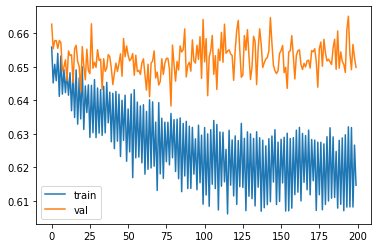

Train accuracy: 0.27952297847585805
Val accuracy: 0.36353944562899787


In [23]:
train(LinearNN1, x1, y1, x_val, y_val,  100, 4096, 0.001)
# train(LinearNN2, x2, y2, x_val, y_val,  50, 4096, 0.001)
# train(LinearNN3, x3, y3, x_val, y_val,  50, 4096, 0.001)

In [15]:
y_train['target']

10285    1
1123     1
3678     1
6888     1
5243     0
2983     0
1517     0
12170    1
1087     1
14569    0
5916     0
9821     0
13754    1
12296    1
576      0
15942    1
2259     0
15462    1
5506     1
0        0
8882     1
2206     1
1338     0
6384     0
13500    1
15070    1
3297     1
15407    1
3357     0
3031     0
        ..
4544     1
13183    1
10025    1
16165    1
14578    0
9263     1
1167     0
10568    1
7411     0
15866    1
3280     1
5935     1
15619    1
3819     0
969      1
8435     1
6235     1
5579     1
10911    0
7462     1
1397     1
13155    1
1099     0
12603    0
9324     1
12858    1
8624     0
5266     0
492      1
15337    0
Name: target, Length: 6876, dtype: int64

Loss after iteration 0: 1.0808428525924683
Elapsed time: 71.02489614486694 s
1.0622118711471558


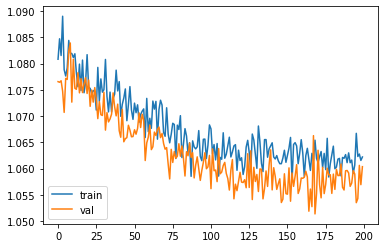

Train accuracy: 0.5218150087260035
Val accuracy: 0.5458422174840085


In [765]:
train(LinearNN3, x3, y3, x_val, y_val,  50, 2048, 0.001)

In [778]:
# torch.save(LinearNN1, './nn1.pt')
# torch.save(LinearNN2, './nn2.pt')
# torch.save(LinearNN3, './nn3.pt')

In [704]:
def ensemble_predict(models, training_data, training_labels, x_val, y_val):
    ensemble = []
    val_pred_ensemble = 0
    for i,model in enumerate(models):
        StandardScaler = preprocessing.StandardScaler().fit(training_data[i].iloc[:,1:])
        X_train = pd.DataFrame(StandardScaler.transform(training_data[i].iloc[:,1:]), index = training_data[i]['match_api_id'], columns = training_data[i].iloc[:,1:].columns)
        X_val = pd.DataFrame(StandardScaler.transform(x_val.iloc[:,1:]), index = x_val['match_api_id'], columns = x_val.iloc[:,1:].columns)
        
        model.eval()
        with torch.no_grad():
            val_pred = model(Tensor(X_val.values))
            train_pred = model(Tensor(X_train.values))
        y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
        y_train_pred = pd.Series(train_pred.max(1).indices).map({0:1,1:0,2:-1})
        
        val_pred_ensemble += val_pred
        print('model: {}'.format(i))
        print('Train accuracy: {}'.format(sklearn.metrics.accuracy_score(y_train_pred, training_labels[i]['result'])))
        print('Val accuracy: {}'.format(sklearn.metrics.accuracy_score(y_val_pred, y_val['result'])))
        
    global y_ens
    y_ens = pd.Series(val_pred_ensemble.max(1).indices).map({0:1,1:0,2:-1})
    print('Ensemble Val accuracy: {}'.format(sklearn.metrics.accuracy_score(y_ens, y_val['result'])))


In [772]:
ensemble_predict([LinearNN1,LinearNN2,LinearNN3], [x1,x2,x3], [y1,y2,y3], x_val, y_val)

model: 0
Train accuracy: 0.5629726585223968
Val accuracy: 0.5362473347547975
model: 1
Train accuracy: 0.5158522396742292
Val accuracy: 0.523454157782516
model: 2
Train accuracy: 0.5218150087260035
Val accuracy: 0.5458422174840085
Ensemble Val accuracy: 0.5511727078891258


In [773]:
ensemble_predict([LinearNN1,LinearNN3], [x1,x3], [y1,y3], x_val, y_val)

model: 0
Train accuracy: 0.5629726585223968
Val accuracy: 0.5362473347547975
model: 1
Train accuracy: 0.5218150087260035
Val accuracy: 0.5458422174840085
Ensemble Val accuracy: 0.5501066098081023


In [774]:
ensemble_predict([LinearNN1,LinearNN2], [x1,x2], [y1,y2], x_val, y_val)

model: 0
Train accuracy: 0.5629726585223968
Val accuracy: 0.5362473347547975
model: 1
Train accuracy: 0.5158522396742292
Val accuracy: 0.523454157782516
Ensemble Val accuracy: 0.5415778251599147


In [775]:
ensemble_predict([LinearNN2,LinearNN3], [x2,x3], [y2,y3], x_val, y_val)

model: 0
Train accuracy: 0.5158522396742292
Val accuracy: 0.523454157782516
model: 1
Train accuracy: 0.5218150087260035
Val accuracy: 0.5458422174840085
Ensemble Val accuracy: 0.5479744136460555


In [707]:
y_ens.value_counts()

 1    1007
-1     305
dtype: int64